## Detecting LULC Classes in Aligarh Using K-Means

In [1]:
import rioxarray
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans

### Loading Raster

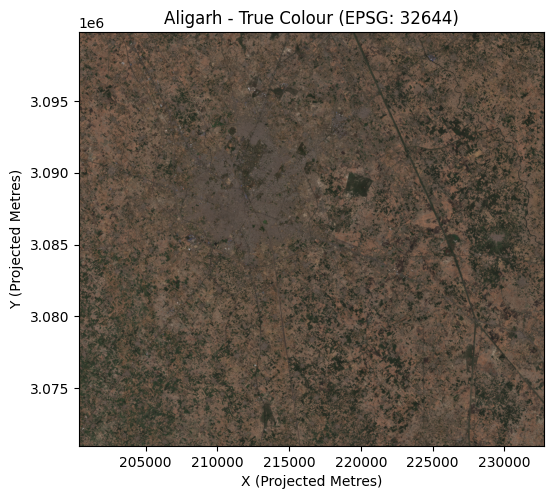

In [2]:
# Loading the raster data
data = rioxarray.open_rasterio('data/aligarh_cropped.tif')

# Selecting individual bands
red = data.sel(band=3)
green = data.sel(band=2)
blue = data.sel(band=1)
nir = data.sel(band=4)

# Creating an RGB array
rgb = xr.concat([red, green, blue], dim='band').transpose('y', 'x', 'band')

# Normalising the array values
rgb_min = rgb.min(dim=('y', 'x'))
rgb_max = rgb.max(dim=('y','x'))
rgb_norm = (rgb - rgb_min) / (rgb_max - rgb_min)

# Deriving geographic extent
bounds = data.rio.bounds()
extent = [bounds[0], bounds[2], bounds[1], bounds[3]]

# Plotting a true colour image
plt.figure(figsize=(6,6))
plt.imshow(rgb_norm.values, extent=extent)
plt.title('Aligarh - True Colour (EPSG: 32644)')
plt.xlabel('X (Projected Metres)')
plt.ylabel('Y (Projected Metres)')
plt.show()

### Calculating NDVI

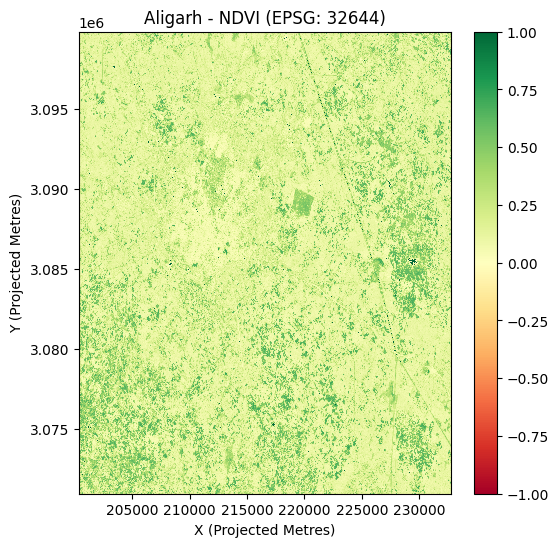

In [3]:
# NDVI calculation and clipping
ndvi = (nir - red) / (nir + red)
ndvi = ndvi.clip(min=-1, max=1)

# Plotting the NDVI image
plt.figure(figsize=(6,6))
ndvi.plot.imshow(vmin=-1, vmax=1, cmap='RdYlGn')
plt.title('Aligarh - NDVI (EPSG: 32644)')
plt.xlabel('X (Projected Metres)')
plt.ylabel('Y (Projected Metres)')
plt.show()

### Data Cleaning

In [4]:
# Stacking all bands into an array
stacked = xr.concat([
    red.drop_vars("band", errors="ignore"),
    green.drop_vars("band", errors="ignore"),
    blue.drop_vars("band", errors="ignore"),
    nir.drop_vars("band", errors="ignore"),
    ndvi
], dim='band')

# Renaming bands
stacked = stacked.assign_coords(band=['red', 'green', 'blue', 'nir', 'ndvi'])

# Rearranging dimensions
stacked = stacked.transpose('y', 'x', 'band')

# Converting to NumPy
arr = stacked.values
pixels = arr.reshape(-1, arr.shape[-1])

# Using a mask to filter NaN values
mask = ~np.any(np.isnan(pixels), axis=1)
pixels_clean = pixels[mask]

# Printing basic statistics
print(f'Total pixels: {pixels.shape[0]}')
print(f'Valid pixels: {pixels_clean.shape[0]}')
print(f'Features per pixel: {pixels_clean.shape[1]}')

Total pixels: 9340562
Valid pixels: 9340562
Features per pixel: 5


### K-Means Clustering

In [5]:
# Range of k values to test
ks = list(range(2,16))
inertias = []

# Running KMeans for each k and recording the inertia
for k in ks:
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=10,
        random_state=42
    )
    labels = kmeans.fit_predict(pixels_clean)
    inertias.append(kmeans.inertia_)
    print(f'K means {k}: inertia = {kmeans.inertia_:.2f} ')

K means 2: inertia = 7507309010283.95 
K means 3: inertia = 4814665811929.23 
K means 4: inertia = 3514322385523.12 
K means 5: inertia = 2945622769596.98 
K means 6: inertia = 2465151357372.27 
K means 7: inertia = 2126400334746.95 
K means 8: inertia = 1901301322926.86 
K means 9: inertia = 1735883889069.64 
K means 10: inertia = 1604242877850.95 
K means 11: inertia = 1480434503684.35 
K means 12: inertia = 1369011174898.60 
K means 13: inertia = 1279439309671.15 
K means 14: inertia = 1206084407614.04 
K means 15: inertia = 1142503984797.75 


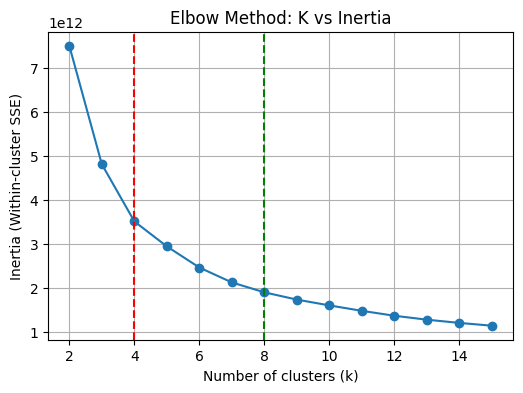

In [6]:
# Plotting the Elbow Method to determine optimum number of clusters
plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker='o')

plt.title('Elbow Method: K vs Inertia')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-cluster SSE)')
plt.grid(True)

# Marking potential elbows: k=4 and k=8
plt.axvline(x=4, color='red', linestyle='--')
plt.axvline(x=8, color='green', linestyle='--')

plt.show()

k = 8 is the optimal number of clusters, as improvements in inertia become minimal beyond that point. However, k = 4 provides a balance between a reasonable decrease in inertia, interpretability of the classes, and avoiding over-splitting of the clusters.

### Visualising Clusters

In [28]:
# Applying KMeans clustering with 4 clusters
kmeans_4 = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=25,
    random_state=42
)
labels_4 = kmeans_4.fit_predict(pixels_clean)

In [29]:
# Getting image dimensions with stacked data
height, width = stacked.sizes["y"], stacked.sizes["x"]

# Creating a label image initialised to -1
label_image = np.full((height * width), fill_value=-1, dtype=np.int32)
label_image[mask] = labels_4
label_image = label_image.reshape((height, width))

# Printing the cluster shape
print(f'cluster image shape: {label_image.shape}')

cluster image shape: (2882, 3241)


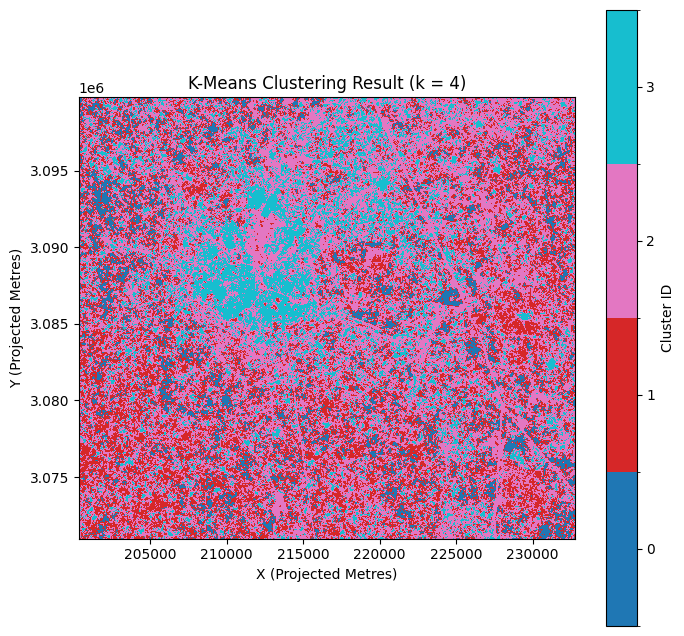

In [32]:
# Defining colourmap and normalisation for visualisation
n_clusters = 4
cmap = plt.get_cmap('tab10', n_clusters)
bounds_2 = np.arange(n_clusters + 1) - 0.5
norm = mcolors.BoundaryNorm(bounds_2, cmap.N)

# Plotting the cluster result
plt.figure(figsize=(8,8))
plt.imshow(label_image, cmap=cmap, norm=norm, extent=extent)
plt.colorbar(ticks=np.arange(n_clusters), label='Cluster ID')

plt.title('K-Means Clustering Result (k = 4)')
plt.xlabel('X (Projected Metres)')
plt.ylabel('Y (Projected Metres)')

# Saving and displaying the output
plt.grid(False)
plt.savefig('data/k_means_output.png')
plt.show()

**Cluster ID 0:** Likely dense vegetation. Appears as scattered compact patches.  
**Cluster ID 1:** Likely bare soil. Appears spread out through out the image.   
**Cluster ID 2:** Likely scattered built-up area and roads. Aligns with the city centre in the true-colour image. Also appears as linear segments, consistent with road shapes.   
**Cluster ID 3:** Likely dense built-up area. Aligns with the city centre in the true-colour image. 

### Exporting the Classified Raster

In [31]:
# Creating a DataArray from the label_image
cluster_da = xr.DataArray(
    label_image.astype(np.int16),  # ensure it's int16
    dims=("y", "x"),
    coords={
        "y": stacked.y,
        "x": stacked.x
    },
    name="cluster"
)

# Assigning CRS and transform
cluster_da.rio.write_crs(stacked.rio.crs, inplace=True)
cluster_da.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

# Exporting the raster
output_path = "data/aligarh_lulc.tif"
cluster_da.rio.to_raster(output_path, compress="deflate")